# MMD for two sample test

## Introduction

Throughout this file, we will deal with the problem of anomalies detection. <br>
Given a data set, the goal is to decide if each element of the data set is normal or anormal <br>
More formaly, we suppose that the normal datas are generated following a probability $p$, the observed data are generated following a probability $q$. The goal is to decide if $p=q$ or not.<br>
To answer this question we can use the $MMD_k(p,q)$.(Greton et al. 2012)<br>
$$
MMD_k(p,q) = ||\mu_p - \mu_q||^{2}_{F_k} = E_{xx'}k(x,x') + E_{yy'}k(y,y') - 2E_{xy}k(x,y)
$$
where :<br>
$k$ is a characteristic kernel<br>
$F_k$ is the Reproducing Kernel Hilbert Space associated to $k$ <br>
$\mu_p$ is the embeding of $p$ in $F_k$<br>
$x,x'$ following $p$ and $y,y'$ following $q$<br>
and $x,x',y,y'$ are independent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

## Kernels

For the MMD-test we need Kernel who respect the characteristic property <br>
According to (Sriperumbudur et al. 2010) we will use the following's kernels.<br>
Gaussian kernel :
$$
k(x,y) = \exp\left(-\frac{||x-y||^{2}_{2}}{2\sigma}\right)
$$
Laplassian kernel:
$$
k(x,y) = \exp\left(-\sigma||x-y||_{1}\right)
$$

In [26]:
# Gaussian 
gaussian = lambda sigma: lambda x,y : np.exp(-np.linalg.norm(x-y,axis=1)**2/(2*sigma))
# Laplacian 
laplacian = lambda sigma: lambda x,y : np.exp(-sigma*np.linalg.norm(x-y,axis=1,ord=1))
#B2n+1-spline
#Bspline = lambda 

Text(0.5,1,'Gaussian kernel')

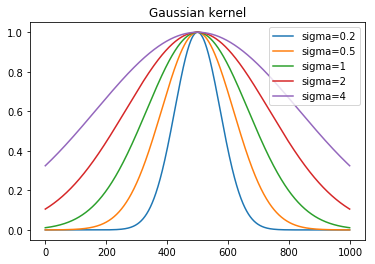

In [48]:
x = np.r_[-3:3:1000j].reshape((1000,1))
for sigma in [0.2,0.5,1,2,4]:
    plt.plot(gaussian(sigma)(x,0),label=f"sigma={sigma}")
plt.legend()
plt.title("Gaussian kernel")

Text(0.5,1,'laplacian kernel')

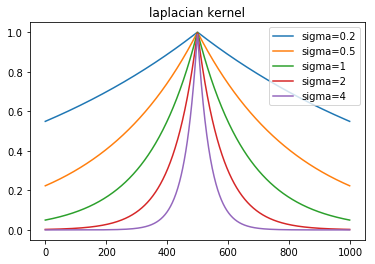

In [47]:
x = np.r_[-3:3:1000j].reshape((1000,1))
for sigma in [0.2,0.5,1,2,4]:
    plt.plot(laplacian(sigma)(x,0),label=f"sigma={sigma}")
plt.legend()
plt.title("laplacian kernel")

A convex combination of charactristic kernel is also a characteristic kernel.<br>
If $(k_i)_{1 \leq i \leq n}$ if a familly of characterisic kernels than : <br>
$$
\left\{ \sum_{0}^{n}t_ik_i~ s.a.~ \sum_{0}^{n}t_i = 1,ti\geq0 ~\forall i\right\} 
$$
Is a set of charactristics kernels.(Greton et al. 2012)




In [74]:
def CCK(kernels_list, weights_list):
    def kernel(x,y):
        res = 0
        for k,w in zip(kernels_list,weights_list):
            res += w*k(x,y)
        return res
    return  kernel

Text(0.5,1,'Convex Combination')

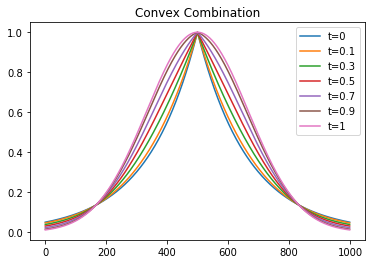

In [88]:
for t in [0,0.1,0.3,0.5,0.7,0.9,1]:
    kernel = CCK([gaussian(1),laplacian(1)],[t,1-t])
    plt.plot(kernel(x,0),label=f"t={t}")
plt.legend()
plt.title("Convex Combination")

## MMD Estimator

### Off line case

We suppose m=n <br>
There is two MMD Estimator.<br>
The MVUE estimator is the following :<br>
$$
MMD_u = \frac{1}{m(m-1)}\sum_{i\neq j}h_k(z_i,z_j) \\
h_k(z_i,z_j) = k(x_i,x_j) + k(y_i,y_j) - k(x_i,y_j) - k(y_i,x_j)
$$
However, this estimator is quadratic in time.<br>
We could also use a linear MMD Estimator
$$
MMD_l = \frac{2}{m}\sum_{i=0}^{m/2}h_k(v_i) \\
h_k(v_i) = k(x_{2i-1},x_{2i}) + k(y_{2i-1},y_{2i}) - k(x_{2i-1},y_{2i}) - k(x_{2i},y_{2i-1})
$$

In [139]:
# Quadratic MMD
def MMDq(X,Y,kernel):
    m = X.shape[0]
    res = 0
    for i in range(m):
        for j in range(m):
            if i != j:
                res += kernel(X[i].reshape((1,-1)),X[j].reshape((1,-1))) + kernel(Y[i].reshape((1,-1)),Y[j].reshape((1,-1))) - kernel(X[i].reshape((1,-1)),Y[j].reshape((1,-1))) - kernel(Y[i].reshape((1,-1)),X[j].reshape((1,-1)))
    return res/(m*(m-1))

# linear MMD     
def MMDl(X,Y,kernel):
    m = X.shape[0]
    res = 0
    for i in range(int(m/2)):
        res += kernel(X[2*i-1].reshape((1,-1)),X[2*i].reshape((1,-1))) + kernel(Y[2*i-1].reshape((1,-1)),Y[2*i].reshape((1,-1))) - kernel(X[2*i-1].reshape((1,-1)),Y[2*i].reshape((1,-1))) - kernel(X[2*i].reshape((1,-1)),Y[2*i-1].reshape((1,-1)))
    return 2*res/m

def MMDl(X,Y,kernel):
    m = X.shape[0]
    res = 0
    for i in range(int(m/2)):
        res += kernel(X[2*i-1].reshape((1,-1)),X[2*i].reshape((1,-1))) + kernel(Y[2*i-1].reshape((1,-1)),Y[2*i].reshape((1,-1))) - kernel(X[2*i-1].reshape((1,-1)),Y[2*i].reshape((1,-1))) - kernel(X[2*i].reshape((1,-1)),Y[2*i-1].reshape((1,-1)))
    return 2*res/m

#### Mean modification - Quadratic MMD

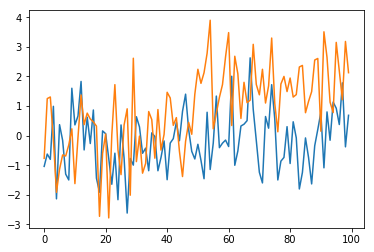

In [210]:
X = np.random.randn(100).reshape((100,1))
Y = np.random.randn(100).reshape((100,1))
T = np.hstack(((np.random.randn(50),np.random.randn(50)+2))).reshape((100,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = CCK([gaussian(1),laplacian(1)],[0.7,0.3])
for i in range(10,100,10):
    MMDliste.append(MMDq(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDq(X[:i],Y[:i],kernel))

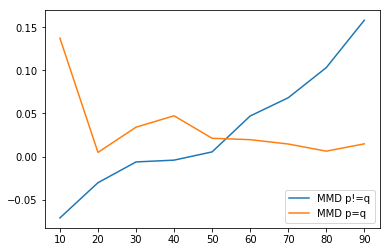

In [211]:
plt.plot(range(10,100,10),MMDliste,label="MMD p!=q")
plt.plot(range(10,100,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Mean modification - linear MMD

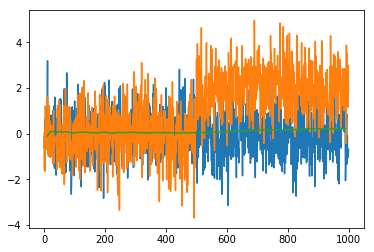

In [182]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
T = np.hstack(((np.random.randn(500),np.random.randn(500)+2))).reshape((1000,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = CCK([gaussian(1),laplacian(1)],[0.7,0.3])
for i in range(10,1000,10):
    MMDliste.append(MMDl(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDl(X[:i],Y[:i],kernel))
plt.plot(range(10,1000,10),L)

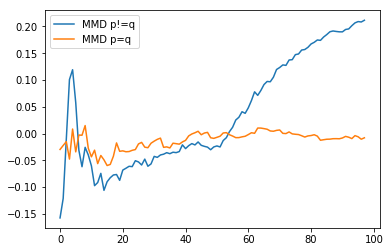

In [183]:
plt.plot(MMDliste[1:],label="MMD p!=q")
plt.plot(MMDTemmoin[1:],label="MMD p=q")
plt.legend()

#### Variance Modification - quadratic MMD

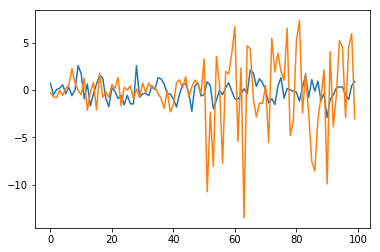

In [215]:
X = np.random.randn(100).reshape((100,1))
Y = np.random.randn(100).reshape((100,1))
T = np.hstack(((np.random.randn(50),np.random.randn(50)*5))).reshape((100,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(10,100,10):
    MMDliste.append(MMDq(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDq(X[:i],Y[:i],kernel))

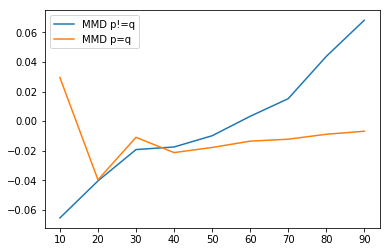

In [217]:
plt.plot(range(10,100,10),MMDliste,label="MMD p!=q")
plt.plot(range(10,100,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Variance Modification - Linear MMD

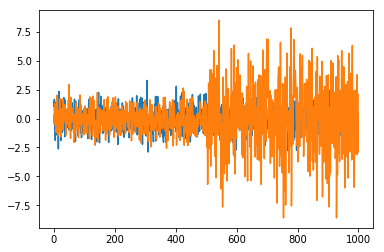

In [199]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
T = np.hstack(((np.random.randn(500),np.random.randn(500)*3))).reshape((1000,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(200,1000,10):
    MMDliste.append(MMDl(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDl(X[:i],Y[:i],kernel))

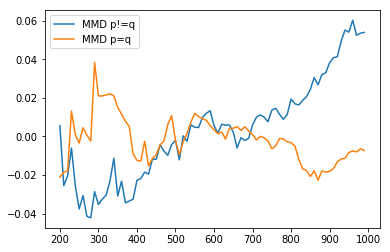

In [200]:
plt.plot(range(200,1000,10),MMDliste,label="MMD p!=q")
plt.plot(range(200,1000,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Law modification - Quadratic MMD

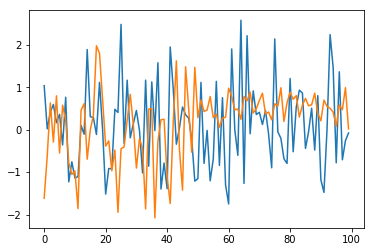

In [219]:
X = np.random.randn(100).reshape((100,1))
Y = np.random.randn(100).reshape((100,1))
T = np.hstack(((np.random.randn(50),np.random.uniform(size=50)))).reshape((100,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(10,100,10):
    MMDliste.append(MMDq(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDq(X[:i],Y[:i],kernel))

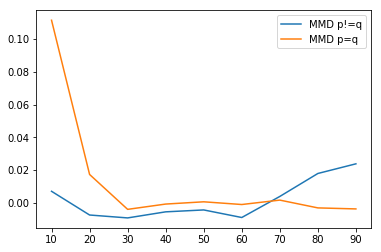

In [220]:
plt.plot(range(10,100,10),MMDliste,label="MMD p!=q")
plt.plot(range(10,100,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Law Modification - Linear MMD

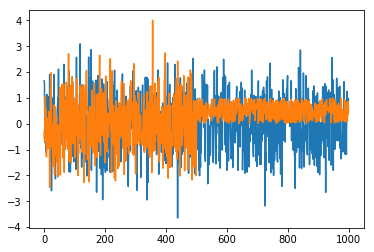

In [202]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
T = np.hstack(((np.random.randn(500),np.random.uniform(size=500)))).reshape((1000,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(200,1000,10):
    MMDliste.append(MMDl(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDl(X[:i],Y[:i],kernel))

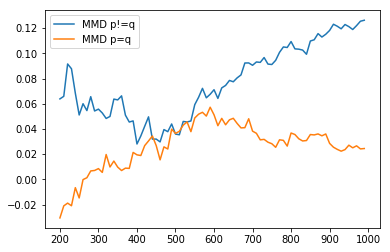

In [203]:
plt.plot(range(200,1000,10),MMDliste,label="MMD p!=q")
plt.plot(range(200,1000,10),MMDTemmoin,label="MMD p=q")
plt.legend()

### On line case

We suppose m > n <br>
The quadratic estimator is the following :<br>
$$
MMD_u = \frac{1}{m^2}\sum k(x_i,x_j) + \frac{1}{n^2}\sum k(y_i,y_j) - \frac{2}{nm}\sum k(x_i,y_j) \\
$$
This is a baised estimator.<br>
We could also use a linear MMD Estimator ??
$$
MMD_l = \frac{2}{m}\sum_{i=0}^{m/2}k(x_{2i},x_{2i-1}) + \frac{2}{n}\sum_{i=0}^{n/2}k(y_{2i},y_{2i-1}) - \frac{2}{n}\sum_{i=0}^{n/2}k(x_{2i},y_{2i-1}) - \frac{2}{n}\sum_{i=0}^{n/2}k(y_{2i},x_{2i-1}) \\
$$

## Références

GRETTON, Arthur, SEJDINOVIC, Dino, STRATHMANN, Heiko, et al. Optimal kernel choice for large-scale two-sample tests. In : Advances in neural information processing systems. 2012. p. 1205-1213

Sriperumbudur, B. K., Gretton, A., Fukumizu, K., Schölkopf, B., & Lanckriet, G. R. (2010). Hilbert space embeddings and metrics on probability measures. Journal of Machine Learning Research, 11(Apr), 1517-1561.